# Data Preperation

In [8]:
# Step 1: Import required libraries and load environment variables

import os
from dotenv import load_dotenv
import pandas as pd
from supabase import create_client, Client

# Load environment variables
load_dotenv()

# Get Supabase credentials from environment variables
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

# Initialize the Supabase client
supabase: Client = create_client(url, key)

# Step 2: Query the audio_files table from Supabase
# This pulls all metadata for the audio files into a pandas DataFrame.
res = supabase.table("audio_files").select(
    "id,bucket_id,object_name,content_type,size_bytes,created_at,top_level_folder,second_level_folder,species"
).execute()

# Convert to DataFrame
df = pd.DataFrame(res.data)
print(df.head())

                                     id   bucket_id  \
0  a1d8e5cc-6391-4b91-97ef-b3270e59f3a5  frog-audio   
1  783e5c27-3c18-4098-a0c5-589cfeddeac0  frog-audio   
2  7d62c4c7-1fc3-4bc8-8175-240caa56703c  frog-audio   
3  2139be56-caaf-4bf6-8c2e-9c72e887575c  frog-audio   
4  f8bae573-c7e5-4ea1-b57f-0b5e168d8c80  frog-audio   

                                         object_name content_type  size_bytes  \
0  digital_library_of_georgia/atlmetro_14_species...   audio/mpeg     1333019   
1  xenocanto/atlmetro_14_species/pickerel_frog/XC...    audio/wav    31773690   
2  macaulay_library/atlmetro_14_species/green_tre...   audio/mpeg      609024   
3  usgs/atlmetro_14_species/spring_peeper/295182.mp3   audio/mpeg      214913   
4  xenocanto/atlmetro_14_species/green_tree_frog/...    audio/wav     1589930   

                         created_at            top_level_folder  \
0   2025-10-20T02:56:33.75325+00:00  digital_library_of_georgia   
1  2025-10-20T21:56:07.847004+00:00             

In [9]:
# Step 3: Quick inspection of object names
# This helps you understand the folder structure and naming conventions for your audio files.
for obj_name in df['object_name']:
    print(obj_name)

digital_library_of_georgia/atlmetro_14_species/green_frog/dlg_ggpd_n200-g2-m1-2013-c3-track-88.mp3
xenocanto/atlmetro_14_species/pickerel_frog/XC895182 - Pickerel Frog - Lithobates palustris.wav
macaulay_library/atlmetro_14_species/green_tree_frog/frog_human/ML183665.mp3
usgs/atlmetro_14_species/spring_peeper/295182.mp3
xenocanto/atlmetro_14_species/green_tree_frog/XC883689 - North American Green Treefrog - Dryophytes cinereus.wav
xenocanto/atlmetro_14_species/spring_peeper/XC796213 - Spring Peeper - Pseudacris crucifer.mp3
macaulay_library/atlmetro_14_species/american_toad/ML182054.mp3
xenocanto/atlmetro_14_species/spring_peeper/XC1020609 - Spring Peeper - Pseudacris crucifer.wav
macaulay_library/atlmetro_14_species/copes_gray_treefrog/ML222925.mp3
macaulay_library/atlmetro_14_species/bird_voiced_tree_frog/frog_human/ML181942.mp3
macaulay_library/atlmetro_14_species/american_toad/ML635754925.mp3
macaulay_library/atlmetro_14_species/american_toad/ML179129.mp3
macaulay_library/atlmetro_

In [10]:
# Step 4: Data Cleaning - Remove unwanted audio instances
# For model training, we want to exclude audio files that contain human speech.
# These are labeled in the 'frog_human' folder, and only occur in the 'macaulay_library' top-level folder.
# This step drops all such instances from the DataFrame.
mask = ~((df['object_name'].str.contains('frog_human')) & (df['top_level_folder'] == 'macaulay_library'))
df_clean = df[mask].reset_index(drop=True)
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")
print(df_clean.head())

Original shape: (1887, 9)
Cleaned shape: (1400, 9)
                                     id   bucket_id  \
0  a1d8e5cc-6391-4b91-97ef-b3270e59f3a5  frog-audio   
1  783e5c27-3c18-4098-a0c5-589cfeddeac0  frog-audio   
2  2139be56-caaf-4bf6-8c2e-9c72e887575c  frog-audio   
3  f8bae573-c7e5-4ea1-b57f-0b5e168d8c80  frog-audio   
4  94f14dd4-c1e2-4a86-83d0-84e664143ba0  frog-audio   

                                         object_name content_type  size_bytes  \
0  digital_library_of_georgia/atlmetro_14_species...   audio/mpeg     1333019   
1  xenocanto/atlmetro_14_species/pickerel_frog/XC...    audio/wav    31773690   
2  usgs/atlmetro_14_species/spring_peeper/295182.mp3   audio/mpeg      214913   
3  xenocanto/atlmetro_14_species/green_tree_frog/...    audio/wav     1589930   
4  xenocanto/atlmetro_14_species/spring_peeper/XC...   audio/mpeg      372755   

                         created_at            top_level_folder  \
0   2025-10-20T02:56:33.75325+00:00  digital_library_of_georgia 

In [11]:
# Step 6: Breakdown of instances per species
# This helps you understand class balance and identify rare species.
species_counts = df_clean['species'].value_counts()
print("Species counts:")
print(species_counts)

Species counts:
species
american_toad                  183
green_tree_frog                180
northern_cricket_frog          164
copes_gray_treefrog            137
american_bullfrog              123
not_frogs                      117
spring_peeper                  106
eastern_narrow_mouthed_toad     97
green_frog                      84
pickerel_frog                   57
fowlers_toad                    40
southern_leopard_frog           36
upland_chorus_frog              32
bird_voiced_tree_frog           27
eastern_spadefoot_toad          17
Name: count, dtype: int64


# Audio Feature Extraction & Analysis


In [12]:
# Step 7: Install librosa for audio analysis
# This library is used for feature extraction and visualization of audio files.
%pip install librosa

Note: you may need to restart the kernel to use updated packages.


Analyzing: digital_library_of_georgia/atlmetro_14_species/green_frog/dlg_ggpd_n200-g2-m1-2013-c3-track-88.mp3
Sample rate: 44100
Duration (seconds): 33.23
Sample rate: 44100
Duration (seconds): 33.23


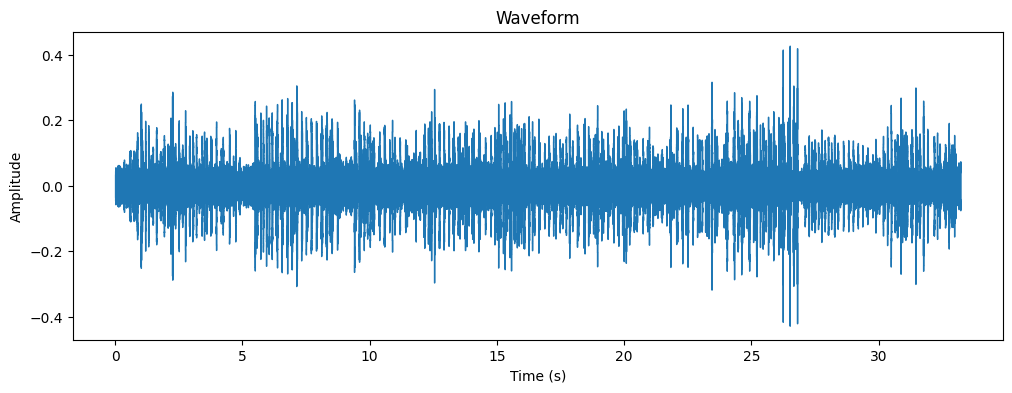

C:\Users\Darling\AppData\Local\Temp\ipykernel_16748\546292286.py:57: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


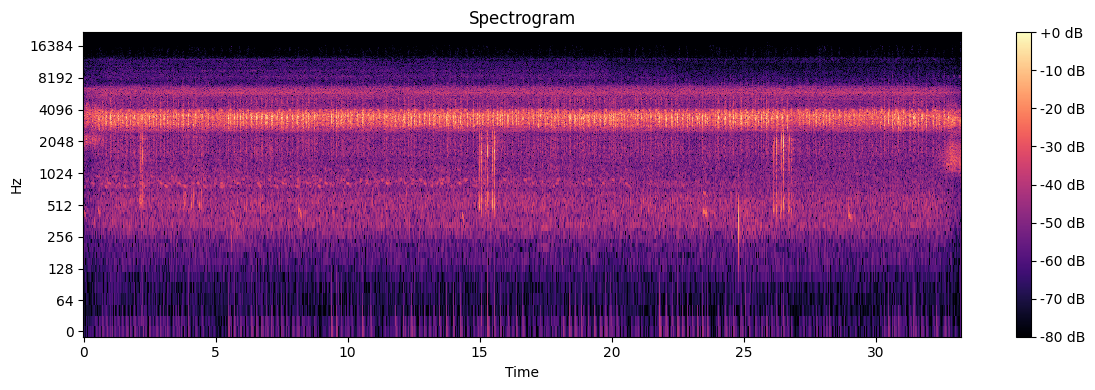

In [13]:
# Download and analyze a sample audio file
# This demonstrates how to fetch an audio file from Supabase, load it, and visualize its properties.
import librosa
import librosa.display
import matplotlib.pyplot as plt
import io
import requests
import tempfile
import os
from IPython.display import Audio
import numpy as np

# Select the first audio file from the cleaned DataFrame
sample_row = df_clean.iloc[0]
bucket_id = sample_row['bucket_id']
object_name = sample_row['object_name']
print('Analyzing:', object_name)

# Download the audio file from Supabase storage
def download_audio(supabase, bucket_id, object_name):
    public_url_response = supabase.storage.from_(bucket_id).get_public_url(object_name)
    # Handle both dict and string return types
    if isinstance(public_url_response, dict):
        public_url = public_url_response.get('publicUrl')
    else:
        public_url = public_url_response
    if not public_url:
        raise Exception('Could not get public URL for file')
    response = requests.get(public_url)
    response.raise_for_status()
    return response.content

audio_bytes = download_audio(supabase, bucket_id, object_name)

# Save to a temporary file
with tempfile.NamedTemporaryFile(delete=False, suffix='.mp3') as tmp_file:
    tmp_file.write(audio_bytes)
    tmp_path = tmp_file.name

# Load audio with librosa
y, sr = librosa.load(tmp_path, sr=None)
print(f'Sample rate: {sr}')
print(f'Duration (seconds): {librosa.get_duration(y=y, sr=sr):.2f}')

# Display audio player
Audio(tmp_path)

# Plot waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Plot spectrogram
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# Clean up temporary file
os.remove(tmp_path)

# Batch Feature Extraction Pipeline

Now that we can successfully load and analyze individual audio files, let's create a pipeline to:
1. Process multiple audio files efficiently
2. Extract consistent features for each sample
3. Create a structured dataset for machine learning

In [14]:
# Feature extraction utilities
def extract_audio_features(y: np.ndarray, sr: int) -> dict:
    """
    Extract comprehensive audio features for frog call classification.
    Args:
        y: Audio time series
        sr: Sampling rate
    Returns:
        Dictionary of features
    """
    features = {}
    
    # Basic features
    features.update({
        'duration': librosa.get_duration(y=y, sr=sr),
        'zero_crossing_rate': librosa.feature.zero_crossing_rate(y).mean(),
        'rms_energy': librosa.feature.rms(y=y)[0].mean(),
    })
    
    # Spectral features
    features.update({
        'spectral_centroid': librosa.feature.spectral_centroid(y=y, sr=sr)[0].mean(),
        'spectral_bandwidth': librosa.feature.spectral_bandwidth(y=y, sr=sr)[0].mean(),
        'spectral_rolloff': librosa.feature.spectral_rolloff(y=y, sr=sr)[0].mean(),
        'spectral_flatness': librosa.feature.spectral_flatness(y=y)[0].mean(),
    })
    
    # Rhythm features
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = tempo
    
    # MFCCs (for timbre analysis)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i, mfcc in enumerate(mfccs):
        features[f'mfcc_{i+1}_mean'] = mfcc.mean()
        features[f'mfcc_{i+1}_std'] = mfcc.std()
    
    return features

def process_audio_file(bucket_id: str, object_name: str, 
                      duration: float = None) -> tuple:
    """
    Process a single audio file from Supabase storage.
    Args:
        bucket_id: Supabase storage bucket ID
        object_name: Path to file in bucket
        duration: Optional duration limit in seconds
    Returns:
        Tuple of (features dict, error message)
    """
    try:
        # Get public URL
        url_response = supabase.storage.from_(bucket_id).get_public_url(object_name)
        if isinstance(url_response, dict):
            url = url_response.get('publicUrl')
        else:
            url = url_response
            
        if not url:
            return None, "Could not get public URL"
            
        # Stream the file
        response = requests.get(url, stream=True)
        response.raise_for_status()
        
        # Load audio directly from memory
        y, sr = librosa.load(io.BytesIO(response.content), sr=None, 
                           duration=duration)
        
        # Extract features
        features = extract_audio_features(y, sr)
        return features, None
        
    except Exception as e:
        return None, str(e)

# Process a small batch as a test
print("Testing batch processing...")
n_samples = 5  # Adjust this number for testing
successful = 0
features_list = []

for idx, row in df_clean.head(n_samples).iterrows():
    print(f"\nProcessing {row['object_name']} ({row['species']})...")
    
    features, error = process_audio_file(
        bucket_id=row['bucket_id'],
        object_name=row['object_name'],
        duration=10.0  # Limit to first 10 seconds
    )
    
    if error:
        print(f"❌ Error: {error}")
        continue
        
    # Add metadata to features
    features.update({
        'species': row['species'],
        'file_name': row['object_name'],
        'source': row['top_level_folder']
    })
    
    features_list.append(features)
    successful += 1
    print("✅ Success")

print(f"\nProcessed {successful}/{n_samples} files successfully")

Testing batch processing...

Processing digital_library_of_georgia/atlmetro_14_species/green_frog/dlg_ggpd_n200-g2-m1-2013-c3-track-88.mp3 (green_frog)...
✅ Success

Processing xenocanto/atlmetro_14_species/pickerel_frog/XC895182 - Pickerel Frog - Lithobates palustris.wav (pickerel_frog)...
✅ Success

Processing xenocanto/atlmetro_14_species/pickerel_frog/XC895182 - Pickerel Frog - Lithobates palustris.wav (pickerel_frog)...
✅ Success

Processing usgs/atlmetro_14_species/spring_peeper/295182.mp3 (spring_peeper)...
✅ Success

Processing usgs/atlmetro_14_species/spring_peeper/295182.mp3 (spring_peeper)...
✅ Success

Processing xenocanto/atlmetro_14_species/green_tree_frog/XC883689 - North American Green Treefrog - Dryophytes cinereus.wav (green_tree_frog)...
✅ Success

Processing xenocanto/atlmetro_14_species/green_tree_frog/XC883689 - North American Green Treefrog - Dryophytes cinereus.wav (green_tree_frog)...
✅ Success

Processing xenocanto/atlmetro_14_species/spring_peeper/XC796213 - 

In [15]:
# Analyze extracted features
if features_list:
    # Convert to DataFrame
    df_features = pd.DataFrame(features_list)
    
    # Basic statistics
    print("\nFeature Statistics:")
    numeric_features = df_features.select_dtypes(include=[np.number]).columns
    print(df_features[numeric_features].describe())
    
    # Feature distributions by species
    print("\nFeature Importance Analysis:")
    for feature in numeric_features:
        if feature not in ['duration', 'tempo']:  # Skip non-normalized features
            continue
        
        print(f"\n{feature}:")
        print(df_features.groupby('species')[feature].agg(['mean', 'std']))
        
    # Save features for later use
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"frog_features_{timestamp}.csv"
    df_features.to_csv(output_file, index=False)
    print(f"\nFeatures saved to {output_file}")
else:
    print("No features to analyze")


Feature Statistics:
        duration  zero_crossing_rate  rms_energy  spectral_centroid  \
count   5.000000            5.000000    5.000000           5.000000   
mean    9.802449            0.126914    0.037089        3475.418943   
std     0.441738            0.095668    0.010943        1856.283279   
min     9.012245            0.025519    0.023044        1389.664149   
25%    10.000000            0.027656    0.030844        2754.585508   
50%    10.000000            0.162378    0.035517        2972.701610   
75%    10.000000            0.181440    0.047224        3868.188179   
max    10.000000            0.237575    0.048817        6391.955271   

       spectral_bandwidth  spectral_rolloff  spectral_flatness  mfcc_1_mean  \
count            5.000000          5.000000           5.000000     5.000000   
mean          3477.607496       6211.361410           0.021404  -323.617981   
std           2146.252132       4210.376789           0.045634    76.042007   
min           1371.4652

In [16]:
import glob
import os
from pathlib import Path

# Recursively find CSV files matching patterns anywhere in the workspace
patterns = ["**/frog_features_*.csv", "**/metadata_*.csv"]
files_removed = 0

for pat in patterns:
    for file in glob.glob(pat, recursive=True):
        try:
            os.remove(file)
            print(f"Removed: {file}")
            files_removed += 1
        except Exception as e:
            print(f"Error removing {file}: {e}")

if files_removed == 0:
    print("No matching feature/metadata CSVs found.")

print("\nCleanup complete. Ready for normalized feature extraction!")

Removed: frog_features_20251101_040618.csv

Cleanup complete. Ready for normalized feature extraction!


Cleanup complete. Ready for normalized feature extraction!


# Full Pipline and Deliverables

Raw Audio → Normalization → Feature Extraction → Save Features
                  ↓                                    ↓
           Processed Audio                       Metadata CSVs
                  ↓
           Augmentation
                  ↓
         Generate Spectrograms

In [17]:
#Raw Audio → Normalization → Feature Extraction → Save Features
                  #↓                                    ↓
           #Processed Audio                       Metadata CSVs
                  #↓
           #Augmentation
                  #↓
         #Generate Spectrograms

# Normalization Pipeline

This section creates clean, consistent audio for modeling:
- Mono, resampled to 22,050 Hz
- Silence trimmed (top_db=30)
- Duration standardized (pad/trim to 10.0 s)
- Amplitude normalized (peak to 0.98)
- Optional pre-emphasis to improve high-frequency detail
- Saved as 16-bit WAV under `data/processed/{species}/`
- Special case: Skip the first 4 seconds for Macaulay Library files (filenames starting with `ML` or `top_level_folder == 'macaulay_library'`) to remove human voice intros

> Note: We normalize first, then re-extract features from these normalized files.

In [ ]:
# Normalization utilities
from pathlib import Path
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm

# Determine repository root as DATA_ROOT so the notebook writes to repo-level `data/` regardless of notebook cwd
cwd = Path.cwd().resolve()
if cwd.name == 'notebooks':
    DATA_ROOT = cwd.parent
else:
    DATA_ROOT = cwd

PROCESSED_DIR = DATA_ROOT / "data" / "processed"
TARGET_SR = 22050
TARGET_DURATION = 10.0  # seconds
PEAK_LEVEL = 0.98  # peak normalization
ML_OFFSET_SEC = 4.0  # skip first 4s for Macaulay Library files to avoid human intros

def ensure_dir(path: Path):
    path.mkdir(parents=True, exist_ok=True)

def to_mono(y: np.ndarray) -> np.ndarray:
    """Convert multi-channel audio to mono handling both channel-first and channel-last shapes.
    Soundfile.read returns (n_samples, n_channels) while librosa.load(mono=False) returns (n_channels, n_samples).
    This helper detects the shape and averages across the channels producing a 1D array of samples.
    """
    if y is None:
        return y
    if y.ndim == 1:
        return y
    # If channels-first (n_channels, n_samples) -> small first dim (1..8), large second dim
    if y.shape[0] <= 8 and y.shape[1] > 8:
        return np.mean(y, axis=0)
    # Else assume samples x channels (n_samples, n_channels) -> average over last axis
    return np.mean(y, axis=-1)

def trim_silence(y: np.ndarray, top_db: float = 30.0) -> np.ndarray:
    yt, _ = librosa.effects.trim(y, top_db=top_db)
    return yt if yt.size > 0 else y

def standardize_duration(y: np.ndarray, sr: int, target_seconds: float) -> np.ndarray:
    target_len = int(target_seconds * sr)
    if y.shape[0] > target_len:
        return y[:target_len]
    if y.shape[0] < target_len:
        pad = target_len - y.shape[0]
        return np.pad(y, (0, pad), mode="constant")
    return y

def peak_normalize(y: np.ndarray, peak: float = PEAK_LEVEL) -> np.ndarray:
    max_val = np.max(np.abs(y)) if y.size else 0.0
    if max_val > 0:
        return (y / max_val) * peak
    return y

def pre_emphasize(y: np.ndarray, coef: float = 0.97) -> np.ndarray:
    # Lightweight emphasis to enhance high frequencies (optional)
    return librosa.effects.preemphasis(y, coef=coef)

def normalize_audio(y: np.ndarray, sr: int, apply_preemphasis: bool = True) -> tuple[np.ndarray, int]:
    # Ensure 1D mono array
    y = to_mono(y)
    # Trim leading/trailing silence
    y = trim_silence(y, top_db=30.0)
    # Resample
    if sr != TARGET_SR:
        y = librosa.resample(y=y, orig_sr=sr, target_sr=TARGET_SR)
        sr = TARGET_SR
    # Standardize duration
    y = standardize_duration(y, sr, TARGET_DURATION)
    # Optional pre-emphasis
    if apply_preemphasis:
        y = pre_emphasize(y)
    # Peak normalize
    y = peak_normalize(y, PEAK_LEVEL)
    return y, sr

def save_wav(y: np.ndarray, sr: int, out_path: Path):
    ensure_dir(out_path.parent)
    # Save as 16-bit PCM WAV
    sf.write(out_path.as_posix(), y, sr, subtype="PCM_16")

def make_output_path(species: str, object_name: str) -> Path:
    # Use the base filename, replace spaces with underscores, force .wav
    base = Path(object_name).name.replace(" ", "_")
    base = Path(base).with_suffix(".wav").name
    return PROCESSED_DIR / species / base

def is_macaulay(row) -> bool:
    try:
        if str(row.get('top_level_folder', '')).lower() == 'macaulay_library':
            return True
    except Exception:
        pass
    try:
        base = Path(str(row['object_name'])).name
        if base.upper().startswith('ML'):
            return True
    except Exception:
        pass
    return False

In [19]:
# Robust audio loading utilities (handles problematic MP3/ML files)
import io, shutil, subprocess, tempfile, glob, os
import numpy as np
import soundfile as _sf

def _find_ffmpeg() -> str | None:
    # Check PATH first
    path = shutil.which("ffmpeg")
    if path:
        return path
    # Fallback: check winget install location (Windows)
    try:
        pattern = os.path.join(os.environ.get('LOCALAPPDATA', ''), 'Microsoft', 'WinGet', 'Packages', 'Gyan.FFmpeg*', 'ffmpeg-*', 'bin', 'ffmpeg.exe')
        matches = glob.glob(pattern)
        if matches:
            return matches[0]
    except Exception:
        pass
    return None

def ffmpeg_info() -> str:
    path = _find_ffmpeg()
    if not path:
        return "ffmpeg: not found on PATH or in winget install location"
    try:
        out = subprocess.run([path, "-version"], capture_output=True, text=True, check=True)
        first = out.stdout.splitlines()[0] if out.stdout else "ffmpeg (no version output)"
        return f"ffmpeg: {path} | {first}"
    except Exception as e:
        return f"ffmpeg: {path} | error reading version: {e}"

def _ffmpeg_available() -> bool:
    return _find_ffmpeg() is not None

def _decode_with_ffmpeg(audio_bytes: bytes, force_mono: bool = False) -> tuple[np.ndarray, int]:
    """
    Decode audio bytes to WAV using the ffmpeg binary. On Windows we must create temp files that ffmpeg can open,
    so create files with mkstemp (which returns a path), write/close them, call ffmpeg, then read and cleanup.
    """
    ffmpeg_path = _find_ffmpeg()
    if not ffmpeg_path:
        raise RuntimeError("ffmpeg is not available on PATH or winget install location. Please install ffmpeg or add it to PATH.")
    # Create temp files (mkstemp returns an open fd and path)
    in_fd, in_path = tempfile.mkstemp(suffix='.bin')
    out_fd, out_path = tempfile.mkstemp(suffix='.wav')
    # Close the low-level fds; we'll open by path so ffmpeg can access them on Windows
    os.close(in_fd)
    os.close(out_fd)
    try:
        with open(in_path, 'wb') as f:
            f.write(audio_bytes)
            f.flush()
        cmd = [
            ffmpeg_path, '-hide_banner', '-loglevel', 'error', '-y', '-i', in_path, '-f', 'wav',
        ] + (['-ac', '1'] if force_mono else []) + [out_path]
        try:
            subprocess.run(cmd, check=True)
        except subprocess.CalledProcessError as e:
            raise RuntimeError(f"ffmpeg failed to decode: {e}\nstderr: {e.stderr if hasattr(e, 'stderr') else ''}")
        y, sr = _sf.read(out_path, dtype="float32", always_2d=False)
        return (y.astype(np.float32, copy=False), int(sr))
    finally:
        # Cleanup temp files if they still exist
        try:
            if os.path.exists(in_path):
                os.remove(in_path)
        except Exception:
            pass
        try:
            if os.path.exists(out_path):
                os.remove(out_path)
        except Exception:
            pass

def load_audio_robust(audio_bytes: bytes, target_sr: int | None = None, mono: bool = False, prefer_ffmpeg: bool = False) -> tuple[np.ndarray, int, str, bool]:
    """
    Robust audio loader with optional ffmpeg preference.
    If prefer_ffmpeg is True, try ffmpeg first then fall back to librosa.
    Otherwise try librosa then ffmpeg.

    Returns (y, sr, loader_used, nonfinite_fixed)
    """
    loader_used = "librosa"
    nonfinite_fixed = False
    y = None
    sr = None
    # If user prefers ffmpeg (e.g., Macaulay Library), try it first
    if prefer_ffmpeg:
        try:
            y, sr = _decode_with_ffmpeg(audio_bytes, force_mono=mono)
            loader_used = "ffmpeg"
        except Exception:
            # fall back to librosa
            try:
                y, sr = librosa.load(io.BytesIO(audio_bytes), sr=None, mono=mono)
                loader_used = "librosa"
                if not np.isfinite(y).all():
                    raise ValueError("Non-finite after librosa.load")
            except Exception:
                # Both attempts failed; re-raise to allow caller to capture
                raise
    else:
        # Default behavior: librosa first, ffmpeg fallback
        try:
            y, sr = librosa.load(io.BytesIO(audio_bytes), sr=None, mono=mono)
            if not np.isfinite(y).all():
                raise ValueError("Non-finite after librosa.load")
        except Exception:
            # Attempt 2: ffmpeg fallback
            y, sr = _decode_with_ffmpeg(audio_bytes, force_mono=mono)
            loader_used = "ffmpeg"
    # Sanitize non-finites just in case
    if not np.isfinite(y).all():
        y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32, copy=False)
        nonfinite_fixed = True
    # Optional resample here (we let normalize_audio handle resampling to TARGET_SR),
    # but if target_sr is explicitly requested, do it.
    if target_sr is not None and int(sr) != int(target_sr):
        y = librosa.resample(y=y, orig_sr=sr, target_sr=target_sr)
        sr = int(target_sr)
    return y, sr, loader_used, nonfinite_fixed

In [21]:
# Normalize a small batch to validate and produce initial metadata
import io, requests, datetime
from dataclasses import dataclass, asdict
import pandas as pd

# ---- Config ----
FULL_RUN = True  # Set True to process all df_clean rows
N_VALIDATE = 20   # Used when FULL_RUN is False
# -----------------

@dataclass
class ProcessedMeta:
    species: str
    source: str
    original_bucket: str
    original_object: str
    processed_path: str
    duration_sec: float
    sample_rate: int
    created_at: str
    offset_applied_sec: float
    loader_used: str
    nonfinite_fixed: bool
    http_content_type: str | None

def download_bytes_from_public_url(bucket_id: str, object_name: str) -> tuple[bytes, str | None]:
    url_response = supabase.storage.from_(bucket_id).get_public_url(object_name)
    if isinstance(url_response, dict):
        url = url_response.get('publicUrl')
    else:
        url = url_response
    if not url:
        raise RuntimeError("Could not get public URL")
    r = requests.get(url, stream=True)
    r.raise_for_status()
    ctype = r.headers.get('Content-Type')
    return r.content, ctype

def process_one_with_offset(row) -> tuple[ProcessedMeta | None, str | None]:
    try:
        audio_bytes, http_ct = download_bytes_from_public_url(row['bucket_id'], row['object_name'])
        # Robust load (librosa -> ffmpeg fallback), don't resample here; normalization will handle it
        try:
            # Prefer ffmpeg for Macaulay Library items to avoid intermittent decoding issues
            prefer = is_macaulay(row)
            y, sr, loader_used, nonfinite_fixed = load_audio_robust(audio_bytes, target_sr=None, mono=False, prefer_ffmpeg=prefer)
        except Exception as e:
            return None, f"Robust load failed: {e} | {ffmpeg_info()}"
        # Immediately convert to mono so offset slicing is unambiguous regardless of channel layout
        try:
            y = to_mono(y)
        except Exception:
            pass
        # Compute offset via overrides if defined, else ML fallback
        try:
            offset = resolve_override_offset(row)
        except NameError:
            offset = ML_OFFSET_SEC if is_macaulay(row) else 0.0
        if offset > 0 and isinstance(y, np.ndarray) and y.size > 0:
            start = int(offset * sr)
            if start < y.shape[0]:
                y = y[start:]
            else:
                # If offset exceeds length, produce empty array to signal error downstream
                y = np.array([], dtype=np.float32)
        y_norm, sr2 = normalize_audio(y, sr)
        out_path = make_output_path(row['species'], row['object_name'])
        save_wav(y_norm, sr2, out_path)
        meta = ProcessedMeta(
            species=row['species'],
            source=row['top_level_folder'],
            original_bucket=row['bucket_id'],
            original_object=row['object_name'],
            processed_path=str(out_path.relative_to(DATA_ROOT)),
            duration_sec=float(librosa.get_duration(y=y_norm, sr=sr2)),
            sample_rate=sr2,
            created_at=datetime.datetime.utcnow().isoformat() + 'Z',
            offset_applied_sec=float(offset),
            loader_used=loader_used,
            nonfinite_fixed=bool(nonfinite_fixed),
            http_content_type=http_ct
        )
        return meta, None
    except Exception as e:
        return None, str(e)

# Backwards-compatible alias used by earlier cells
process_one = process_one_with_offset

# Selection for this run
selection = df_clean if FULL_RUN else df_clean.head(N_VALIDATE)
print(f"Normalizing {'all' if FULL_RUN else f'up to {N_VALIDATE}'} files...")

processed_meta: list[ProcessedMeta] = []
errors = 0
for _, row in tqdm(selection.iterrows(), total=len(selection)):
    meta, err = process_one(row)
    if err:
        errors += 1
        print(f"Error: {row['object_name']} -> {err}")
    else:
        processed_meta.append(meta)

print(f"Done. Success: {len(processed_meta)} | Errors: {errors}")

# Save metadata
if processed_meta:
    df_proc = pd.DataFrame([asdict(m) for m in processed_meta])
    ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    meta_file = DATA_ROOT / f"metadata_processed_{ts}.csv"
    df_proc.to_csv(meta_file, index=False)
    print(f"Saved processed metadata: {meta_file}")
else:
    print("No files processed.")

Normalizing all files...


  0%|          | 0/1400 [00:00<?, ?it/s]C:\Users\Darling\AppData\Local\Temp\ipykernel_16748\392225135.py:77: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  created_at=datetime.datetime.utcnow().isoformat() + 'Z',
  0%|          | 1/1400 [00:01<41:53,  1.80s/it]C:\Users\Darling\AppData\Local\Temp\ipykernel_16748\392225135.py:77: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  created_at=datetime.datetime.utcnow().isoformat() + 'Z',
100%|██████████| 1400/1400 [57:40<00:00,  2.47s/it]  


Done. Success: 1400 | Errors: 0
Saved processed metadata: c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\notebooks\metadata_processed_20251101_050842.csv


In [22]:
# Preview cell: play up to 3 processed WAVs (or fallback to downloading 3 files)
from IPython.display import Audio, display
from pathlib import Path
import tempfile, os

# Look for processed WAVs written by the normalization step
proc_files = sorted(PROCESSED_DIR.glob('**/*.wav'))
n = min(3, len(proc_files))
if n >= 1:
    print(f'Playing {n} processed WAV(s) from {PROCESSED_DIR}')
    for p in proc_files[:3]:
        print(p)
        display(Audio(filename=str(p), autoplay=False))
else:
    print('No processed WAVs found. Falling back to download 3 files from df_clean (may be remote).')
    cnt = 0
    for _, row in df_clean.head(3).iterrows():
        try:
            audio_bytes, _ = download_bytes_from_public_url(row['bucket_id'], row['object_name'])
            with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as tmp:
                tmp.write(audio_bytes)
                tmp_path = tmp.name
            print(f'Playing downloaded preview: {row["object_name"]}')
            display(Audio(tmp_path, autoplay=False))
            os.remove(tmp_path)
            cnt += 1
        except Exception as e:
            print('Preview download failed for', row['object_name'], '->', e)
    if cnt == 0:
        print('No previews available.')

Playing 3 processed WAV(s) from c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\notebooks\data\processed
c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\notebooks\data\processed\american_bullfrog\03-Bullfrog-call-1.wav


c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\notebooks\data\processed\american_bullfrog\375155.wav


c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\notebooks\data\processed\american_bullfrog\American_Bullfrog_(Rana_catesbeiana)_-_Mating_and_Display_Calls.wav


# Feature extraction

In [23]:
# Feature extraction: save log-mel spectrograms (.npy) and PNG previews, then create stratified train/val/test metadata CSVs
# Defaults: n_mels=64, n_fft=1024, hop_length=512, store .npy + PNG previews

from pathlib import Path
import numpy as np
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

# Parameters (change here for future experiments)
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 512
POWER = 2.0  # 2.0 => power spectrogram used by melspectrogram

SPEC_ROOT = DATA_ROOT / "data" / "spectrograms"
SPEC_PREV = SPEC_ROOT / "preview"

# Ensure directories exist
ensure_dir(SPEC_ROOT)
ensure_dir(SPEC_PREV)

# Walk processed WAVs and compute spectrograms
rows = []
failed = []

wav_paths = sorted(PROCESSED_DIR.glob("**/*.wav"))
print(f"Found {len(wav_paths)} processed WAV files under {PROCESSED_DIR}")

for wav_path in tqdm(wav_paths, desc="Extracting spectrograms"):
    try:
        # Read audio (soundfile to preserve float32 behaviour)
        y, sr = sf.read(wav_path, dtype='float32')
        # Convert multi-channel to mono if needed
        if y.ndim > 1:
            y = np.mean(y, axis=1)
        # Resample if needed
        if int(sr) != int(TARGET_SR):
            y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
            sr = TARGET_SR
        # Ensure length (should already be standardized to TARGET_DURATION, but double-check)
        # Compute mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, power=POWER)
        S_db = librosa.power_to_db(S, ref=np.max)
        # Paths: keep species subfolder structure from PROCESSED_DIR
        rel = wav_path.relative_to(PROCESSED_DIR)
        spec_path = SPEC_ROOT / rel.with_suffix('.npy')
        preview_path = SPEC_PREV / rel.with_suffix('.png')
        # Ensure parent dirs
        spec_path.parent.mkdir(parents=True, exist_ok=True)
        preview_path.parent.mkdir(parents=True, exist_ok=True)
        # Save .npy
        np.save(spec_path, S_db.astype(np.float32))
        # Save PNG preview (compact)
        plt.figure(figsize=(6, 3))
        librosa.display.specshow(S_db, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='magma')
        plt.colorbar(format='%+2.0f dB')
        plt.title(wav_path.name)
        plt.tight_layout()
        plt.savefig(preview_path, dpi=150)
        plt.close()
        # Gather metadata row
        species = wav_path.parent.name
        rows.append({
            'file_id': rel.stem,
            'species': species,
            'processed_path': str(wav_path.relative_to(DATA_ROOT)),
            'spectrogram_path': str(spec_path.relative_to(DATA_ROOT)),
            'preview_path': str(preview_path.relative_to(DATA_ROOT)),
            'duration_sec': float(librosa.get_duration(y=y, sr=sr)),
            'sample_rate': int(sr),
        })
    except Exception as e:
        failed.append((str(wav_path), str(e)))

print(f"Spectrogram extraction complete. Success: {len(rows)} | Failed: {len(failed)}")
if failed:
    print("Some files failed to process (first 10 shown):")
    for p, err in failed[:10]:
        print(p, "->", err)

# Build DataFrame of extracted items
if not rows:
    raise RuntimeError("No spectrograms were extracted. Check processed WAVs and rerun normalization if needed.")

df_specs = pd.DataFrame(rows)

# Create stratified train/val/test splits (70/15/15) with fallback to non-stratified if stratify not possible
train_frac = 0.70
val_frac = 0.15
test_frac = 0.15

# shuffle dataframe
df_specs = df_specs.sample(frac=1.0, random_state=42).reset_index(drop=True)

try:
    train_df, temp_df = train_test_split(df_specs, test_size=(1 - train_frac), stratify=df_specs['species'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=(test_frac / (test_frac + val_frac)), stratify=temp_df['species'], random_state=42)
except Exception as e:
    print("Stratified split failed (likely small classes). Falling back to random split. Error:", e)
    n = len(df_specs)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    train_df = df_specs.iloc[:n_train]
    val_df = df_specs.iloc[n_train:n_train + n_val]
    test_df = df_specs.iloc[n_train + n_val:]

# Save metadata CSVs to DATA_ROOT
meta_train = DATA_ROOT / 'metadata_train.csv'
meta_val = DATA_ROOT / 'metadata_val.csv'
meta_test = DATA_ROOT / 'metadata_test.csv'

train_df.to_csv(meta_train, index=False)
val_df.to_csv(meta_val, index=False)
test_df.to_csv(meta_test, index=False)

print(f"Saved metadata: {meta_train} ({len(train_df)} rows)")
print(f"Saved metadata: {meta_val} ({len(val_df)} rows)")
print(f"Saved metadata: {meta_test} ({len(test_df)} rows)")

# Save a short data preparation report (markdown)
report_lines = [
    "# Data Preparation Report",
    "",
    "## Summary",
    f"Processed WAVs: {len(wav_paths)}",
    f"Spectrograms extracted: {len(df_specs)}",
    "",
    "## Spectrogram parameters",
    f"- n_mels: {N_MELS}",
    f"- n_fft: {N_FFT}",
    f"- hop_length: {HOP_LENGTH}",
    f"- power: {POWER}",
    "",
    "## Train/Val/Test splits",
    f"- train: {len(train_df)}",
    f"- val: {len(val_df)}",
    f"- test: {len(test_df)}",
    "",
    "## Notes",
    "- Spectrograms are saved as log-mel dB arrays (.npy) and PNG previews under data/spectrograms/preview/.",
    "- If stratified splitting failed due to small classes, a random split was used as a fallback.",
]

report_path = DATA_ROOT / 'data_preparation_report.md'
with open(report_path, 'w', encoding='utf8') as f:
    f.write('\n'.join(report_lines))

print(f"Wrote data preparation report: {report_path}")

# Summary display
species_counts = df_specs['species'].value_counts()
print('\nSpecies counts (top 20):')
print(species_counts.head(20))

print('\nDone. You can find spectrogram .npy files under:', SPEC_ROOT)
print('PNG previews under:', SPEC_PREV)
print('Metadata CSVs at repo root: metadata_train.csv, metadata_val.csv, metadata_test.csv')

Found 1400 processed WAV files under c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\notebooks\data\processed


Extracting spectrograms: 100%|██████████| 1400/1400 [20:02<00:00,  1.16it/s] 

Spectrogram extraction complete. Success: 1400 | Failed: 0
Saved metadata: c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\notebooks\metadata_train.csv (979 rows)
Saved metadata: c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\notebooks\metadata_val.csv (210 rows)
Saved metadata: c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\notebooks\metadata_test.csv (211 rows)
Wrote data preparation report: c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\notebooks\data_preparation_report.md

Species counts (top 20):
species
american_toad                  183
green_tree_frog                180
northern_cricket_frog          164
copes_gray_treefrog            137
american_bullfrog              123
not_frogs                      117
spring_peeper                  106
eastern_narrow_mouthed_toad     97
green_frog                      84
pickerel_frog                   57
fowlers_toad            